<a href="https://colab.research.google.com/github/Oriel32/stock_predictions_ML_DL/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier, XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Embedding, Conv1D, Flatten, Bidirectional, GlobalAveragePooling1D, SimpleRNN, GlobalMaxPooling1D,GRU, Lambda, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
stock_data = yf.download("LMT", start="2018-07-18", end="2020-07-18")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,LMT,LMT,LMT,LMT,LMT
Date,,,,,
2018-07-18,267.078796,267.755324,264.347631,265.358242,860400
2018-07-19,266.936737,267.989099,265.750712,266.686155,759900
2018-07-20,269.400696,269.651278,265.132726,265.892781,1563900
2018-07-23,265.876038,270.194144,264.589815,269.400673,1585300
2018-07-24,269.417328,275.330683,261.424254,271.446909,3253400


In [ ]:
!unzip fnews.zip -d fnews

Archive:  fnews.zip
  inflating: fnews/cnbc_headlines.csv  
  inflating: fnews/guardian_headlines.csv  
  inflating: fnews/reuters_headlines.csv  


In [ ]:
cnbc = pd.read_csv('fnews/cnbc_headlines.csv')
guardian = pd.read_csv('fnews/guardian_headlines.csv')
reuters = pd.read_csv('fnews/reuters_headlines.csv')

In [ ]:
cnbc.tail()

,Headlines,Time,Description
3075,Markets lack Christmas cheer,"10:15 AM ET Tue, 26 Dec 2017","According to Kensho, here's how markets have f..."
3076,Cramer Remix: The biggest mistake you can make...,"11:12 AM ET Thu, 20 Sept 2018",Jim Cramer revealed his top rule when it comes...
3077,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017",Jim Cramer broke down why owning fewer stocks ...
3078,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017","Jim Cramer built on his ""nobody ever made a di..."
3079,Cramer: Never buy a stock all at once — you'll...,"6:52 PM ET Fri, 22 Dec 2017",Jim Cramer doubled down on his key investing r...


In [ ]:
guardian.tail()

,Time,Headlines
17795,17-Dec-17,How investing in solar energy can create a bri...
17796,17-Dec-17,Poundland suppliers hit by insurance downgrade
17797,17-Dec-17,Cryptocurrencies: City watchdog to investigate...
17798,17-Dec-17,Unilever sells household name spreads to KKR f...
17799,17-Dec-17,The Guardian view on Ryanair’s model: a union-...


In [ ]:
reuters.tail()

,Headlines,Time,Description
32765,Malaysia says never hired British data firm at...,Mar 20 2018,The Malaysian government and the ruling party ...
32766,Prosecutors search Volkswagen headquarters in ...,Mar 20 2018,German prosecutors said on Tuesday they had se...
32767,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,McDonald's Corp on Tuesday announced an approv...
32768,Pratt & Whitney to deliver spare A320neo engin...,Mar 20 2018,Pratt & Whitney will soon begin deliveries of ...
32769,UK will always consider ways to improve data l...,Mar 20 2018,Britain will consider any suggestions to give ...


Decided to use Reuters for headlines and descriptions—clear, concise, and free from exaggeration or clickbait.

introduction and EDA

In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2018-07-18 to 2020-07-17
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, LMT)   504 non-null    float64
 1   (High, LMT)    504 non-null    float64
 2   (Low, LMT)     504 non-null    float64
 3   (Open, LMT)    504 non-null    float64
 4   (Volume, LMT)  504 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 23.6 KB


In [ ]:
stock_data.reset_index(inplace=True)

In [ ]:
stock_data.columns = [col[0] for col in stock_data.columns]

In [ ]:
stock_data.set_index('Date', inplace=True)

In [ ]:
stock_data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2018-07-18,267.078796,267.755324,264.347631,265.358242,860400
2018-07-19,266.936737,267.989099,265.750712,266.686155,759900
2018-07-20,269.400696,269.651278,265.132726,265.892781,1563900
2018-07-23,265.876038,270.194144,264.589815,269.400673,1585300
2018-07-24,269.417328,275.330683,261.424254,271.446909,3253400


In [ ]:
reuters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


In [ ]:
reuters['Time'] = pd.to_datetime(reuters['Time'])

In [ ]:
# rename time column to date to match stock data dataset
reuters = reuters.rename(columns={'Time':'Date'})

In [ ]:
reuters.set_index('Date', inplace=True)

In [ ]:
reuters.sort_index(ascending=True, inplace=True)

In [ ]:
reuters = reuters.loc["2018-07-18":"2020-07-18"]

In [ ]:
reuters.head()

,Headlines,Description
Date,,
2018-07-18,AmEx rewards program costs cloud strong quarte...,American Express Co reported a steep rise in ...
2018-07-18,Trump says U.S. may pursue separate trade deal...,President Donald Trump said on Wednesday the U...
2018-07-18,"World stocks climb to month peak, U.S. dollar ...",Stocks on major world markets climbed to a one...
2018-07-18,Europe hits Google with record $5 billion anti...,European antitrust regulators fined Google a r...
2018-07-18,Exclusive: Investment firms fight to inject ca...,Three distressed asset funds have sued for the...


In [ ]:
reuters.tail()

,Headlines,Description
Date,,
2020-07-17,Exclusive: Pact to aid poor cocoa farmers in p...,The steepest dive in cocoa demand in a decade ...
2020-07-18,Twitter says attackers downloaded data from up...,Twitter Inc said on Saturday that hackers were...
2020-07-18,Trail of missing Wirecard executive leads to B...,Former Wirecard chief operating officer Jan M...
2020-07-18,Disney cuts ad spending on Facebook amid growi...,Walt Disney has become the latest company to ...
2020-07-18,TikTok considers London and other locations fo...,TikTok has been in discussions with the UK gov...


In [ ]:
reuters['Headlines'].nunique()

28045

In [ ]:
reuters['Headlines'].count()

np.int64(28211)

In [ ]:
# show duplicate Headlines and their date
duplicate_descriptions = reuters[reuters.duplicated(subset='Headlines', keep = False)]
duplicate_descriptions.sort_values(by='Headlines').head(6)

,Headlines,Description
Date,,
2018-08-14,A look at Tesla's nine-member board,Tesla Inc's board has named a special committe...
2018-08-08,A look at Tesla's nine-member board,Tesla Inc's board has said it is evaluating t...
2019-11-15,AirAsia to sell tickets on other airlines as p...,Malaysian budget carrier AirAsia Group Bhd sai...
2019-11-15,AirAsia to sell tickets on other airlines as p...,Malaysian budget carrier AirAsia Group Bhd sai...
2018-12-12,Amazon aims at office workers with compact cas...,Amazon.com Inc on Wednesday opened a compact v...
2018-12-12,Amazon aims at office workers with compact cas...,Amazon.com Inc on Wednesday opened a compact v...


In [ ]:
# drop duplicate Headlines
reuters.drop_duplicates(subset=['Headlines'], keep='first', inplace=True)

stock data analysis

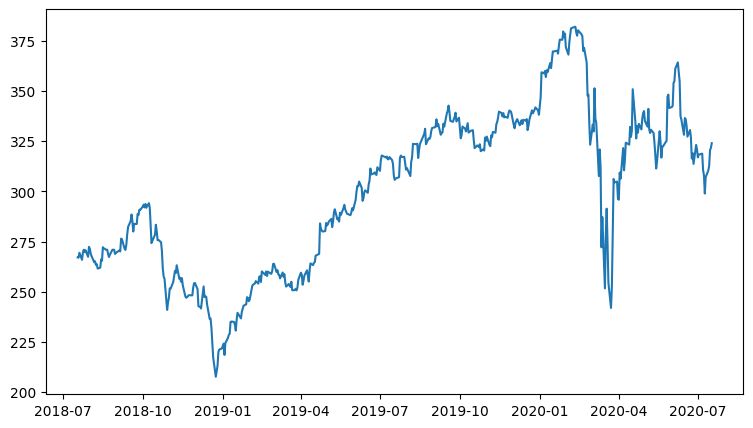

In [ ]:
fig, axs = plt.subplots(1 , figsize=(9, 5))
plt.plot(stock_data['Close'], label='Close Price')
plt.show()

In [ ]:
stock_data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2018-07-18,267.078796,267.755324,264.347631,265.358242,860400
2018-07-19,266.936737,267.989099,265.750712,266.686155,759900
2018-07-20,269.400696,269.651278,265.132726,265.892781,1563900
2018-07-23,265.876038,270.194144,264.589815,269.400673,1585300
2018-07-24,269.417328,275.330683,261.424254,271.446909,3253400


In [ ]:
stock_data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2020-07-13,310.409943,313.891563,306.488723,310.884718,2031300
2020-07-14,312.695831,312.924432,306.840364,306.954665,1651900
2020-07-15,320.520691,321.417464,317.003896,317.953446,1617300
2020-07-16,321.681244,321.733994,315.649927,318.533697,955400
2020-07-17,323.984772,324.424371,319.017304,322.050524,1135500


In [ ]:
stock_data.describe()

,Close,High,Low,Open,Volume
count,504.000000,504.000000,504.000000,504.000000,5.040000e+02
mean,300.100733,303.145198,296.976751,300.160320,1.362318e+06
std,39.460068,39.679490,39.419726,39.539325,6.247411e+05
min,207.603897,213.250757,204.183637,208.526713,4.015000e+05
25%,264.311996,266.297822,261.263631,264.800099,9.483000e+05
50%,306.993225,309.655509,303.450519,307.000588,1.189500e+06
75%,331.194458,334.729505,328.766659,331.553833,1.565025e+06
max,381.987549,384.314987,380.224629,383.298890,4.516500e+06


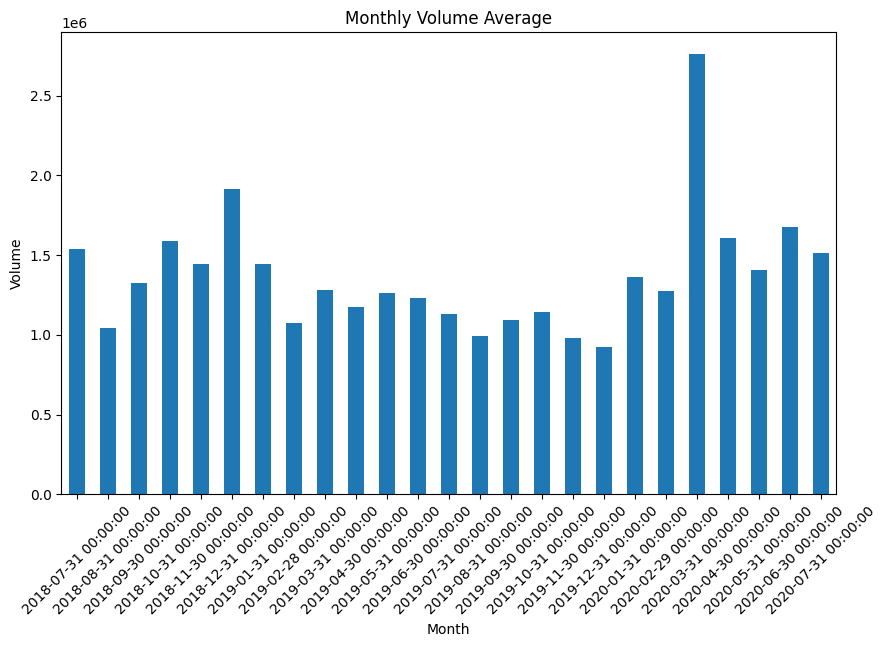

In [ ]:
monthly_volume = stock_data.resample('ME')['Volume'].mean()

plt.figure(figsize=(10, 6))
monthly_volume.plot(kind='bar')
plt.title('Monthly Volume Average')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()

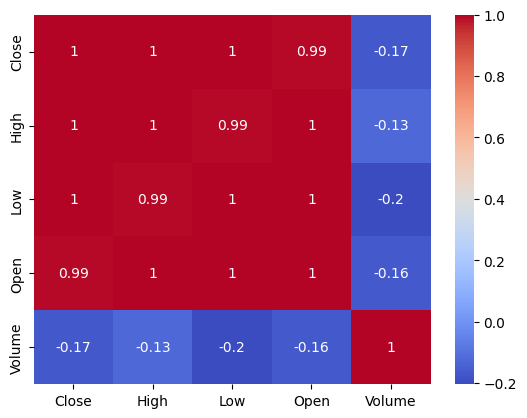

In [ ]:
sns.heatmap(stock_data.select_dtypes(['number']).corr(), cmap='coolwarm', annot = True)
plt.show()

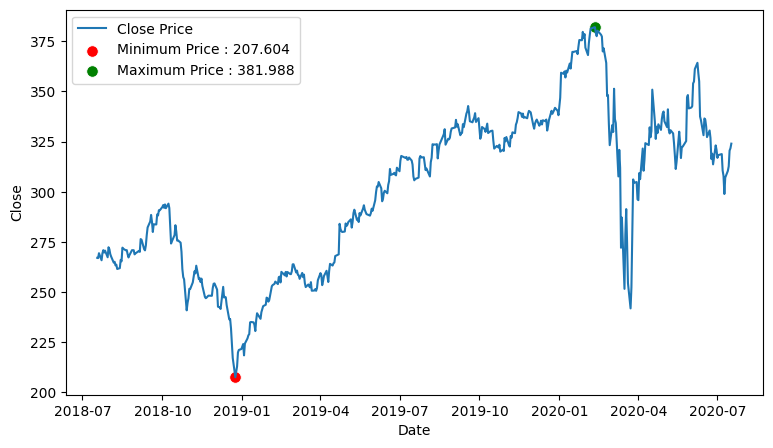

In [ ]:
maskmin = stock_data['Close'] == stock_data['Close'].min()
maskmax = stock_data['Close'] == stock_data['Close'].max()
fig, axs = plt.subplots(1 , figsize=(9, 5))
axs.plot(stock_data['Close'], label='Close Price')
sns.scatterplot(stock_data[maskmin]['Close'], c = 'red', s = 70, label = f"Minimum Price : {round(stock_data.loc[maskmin, 'Close'].values[0], 3)}", ax=axs)
sns.scatterplot(stock_data[maskmax]['Close'], c = 'green', s = 70, label = f"Maximum Price : {round(stock_data.loc[maskmax, 'Close'].values[0], 3)}", ax=axs)
plt.legend()
plt.show()

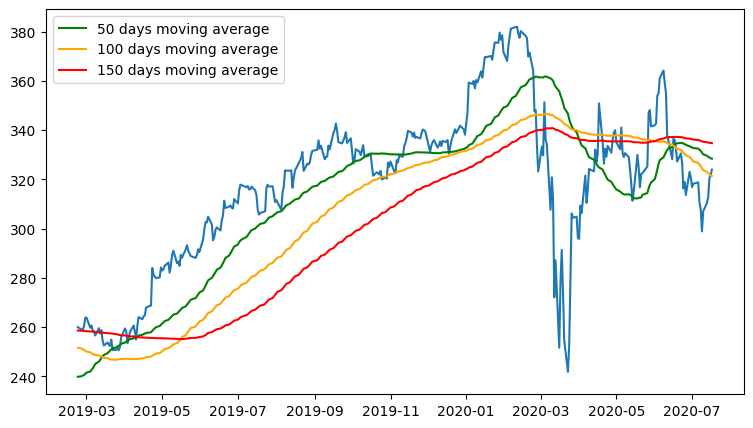

In [ ]:
# 50, 100, 150 moving average graphs to show changes in a varient time windows
fig, axs = plt.subplots(1 , figsize=(9, 5))
plt.plot(stock_data['Close'].iloc[150:])
plt.plot(stock_data['Close'].rolling(window=50).mean().iloc[150:], label = '50 days moving average', color = 'green')
plt.plot(stock_data['Close'].rolling(window=100).mean().iloc[150:], label = '100 days moving average', color = 'orange')
plt.plot(stock_data['Close'].rolling(window=150).mean().iloc[150:], label = '150 days moving average', color = 'red')
plt.legend()
plt.show()

In [ ]:
df_quarters = stock_data.copy()
df_quarters['quarter'] = df_quarters.index.quarter
grp = df_quarters.groupby('quarter')

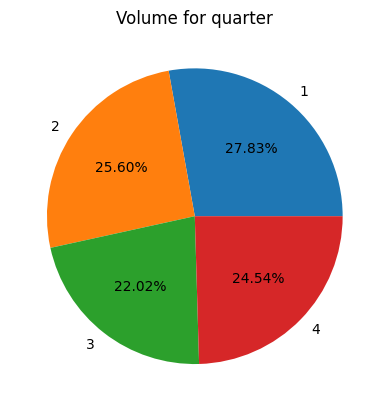

In [ ]:
# Volume for quarter pie
plt.pie(grp['Volume'].sum(), labels = grp.size().index, autopct='%1.2f%%')
plt.title('Volume for quarter')
plt.show()

reuters news data analysis

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# DownLoad
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# define
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# clean sentences function
def clean_text(text):
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]  # lemm&stop words cleaning
    return " ".join(words)  # return text without stop words

# loop all sentences
news_description = [clean_text(text) for text in reuters['Description']]

In [ ]:
# tokenize the words in the cleaned descriptions and give each sentence a sequence and a padded sequence
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(news_description)
sequence = tokenizer.texts_to_sequences(news_description)
maxlen = len(max(sequence, key = len))
padded = pad_sequences(sequence, padding='pre', maxlen=maxlen)

In [ ]:
sentences = [len(i) for i in news_description]

In [ ]:
min_len = np.min(sentences)

In [ ]:
max_len = np.max(sentences)

In [ ]:
mean_len = np.mean(sentences)

In [ ]:
max_words = np.max([len(i) for i in sequence])

In [ ]:
min_words = np.min([len(i) for i in sequence])

In [ ]:
mean_words = np.mean([len(i) for i in sequence])

In [ ]:
# print short analayze about sentences length
print(f"min length sentence : {min_len}")
print(f"max length sentence: {max_len}")
print(f"Average sentence length : {mean_len : .2f}\n")

# print short analayze about the number of words in texts
print(f"min words in a sentence: {min_words}")
print(f"max words in a sentence: {max_words}")
print(f"Average words count for a sentence: {mean_words : .2f}")

min length sentence : 25
max length sentence: 486
Average sentence length :  171.01

min words in a sentence: 3
max words in a sentence: 60
Average words count for a sentence:  24.23


In [ ]:
# print the most common words
print ("most common words :")
for i, value in enumerate(tokenizer.word_index):
    print(i, value)
    if i > 11:
        break

most common words :
0 <OOV>
1 's
2 said
3 u
4 s
5 inc
6 company
7 year
8 thursday
9 wednesday
10 tuesday
11 china
12 coronavirus


In [ ]:
common_words = list(tokenizer.word_index.keys())
# Remove elements at specified indices
del common_words[1]
del common_words[2] # index 3 in original list after deleting index 1
del common_words[2] # index 4 in original list after deleting index 1 and 3

print ("most common words:")
for i, word in enumerate(common_words):
    print(i, word)
    if i > 11:
        break


most common words:
0 <OOV>
1 said
2 inc
3 company
4 year
5 thursday
6 wednesday
7 tuesday
8 china
9 coronavirus
10 billion
11 trade
12 monday


In [ ]:
# create target column - 1 if the stock went up, -1 if the stock went down, 0 if the stock changed a bit

In [ ]:
# make 'Change' column in proportion to the percentage change in stock value from the previous row
stock_data['Change'] = (stock_data['Close'] - stock_data['Close'].shift(+1))/stock_data['Close'].shift(+1)

In [ ]:
stock_data['Change'] = stock_data['Change'].fillna(0)

In [ ]:
stock_data['Change'] = stock_data['Change'].apply(lambda x: 1 if x > 0.01 else -1 if x < -0.01 else 0)
# stock_data['Change'] = stock_data['Change'].apply(lambda x: 1 if np.abs(x) > 0.01 else 0)

In [ ]:
stock_data['Change'].head(10)

,Change
Date,
2018-07-18,0
2018-07-19,0
2018-07-20,0
2018-07-23,-1
2018-07-24,1
2018-07-25,0
2018-07-26,0
2018-07-27,0
2018-07-30,-1


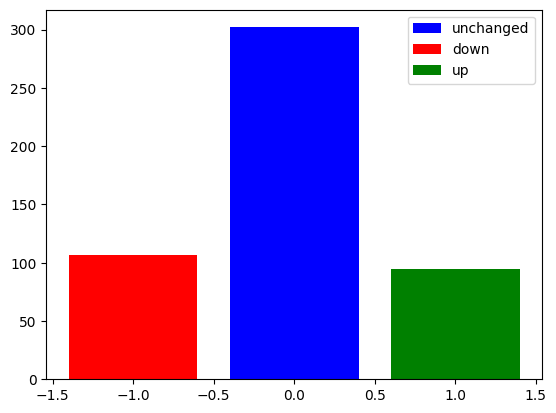

In [ ]:
# plot data - color based on Change column, label for each bar
plt.bar(stock_data['Change'].unique(), height=stock_data['Change'].value_counts(), color = ['blue', 'red', 'green'], label = ['unchanged', 'down', 'up'])
plt.legend()
plt.show()

In [ ]:
# classic models classification - target column : 'Change'
X = stock_data.drop('Change', axis=1)
y = stock_data['Change']

# change labels to [0, 1, 2] for xgboost classification
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# split to train and test
split_time = int(len(X)*0.8)
X_train, X_test = X[:split_time], X[split_time:]
y_train, y_test = y[:split_time], y[split_time:]

# scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create models dictionary to loop
models = {"logistic regrssion" : LogisticRegression(C = 10, solver = 'lbfgs'),
          "random forest" : RandomForestClassifier(n_estimators=250, min_samples_split=2, random_state=1),
          "xgboost" : XGBClassifier(eval_metric = 'mlogloss', objective='multi:softmax', tree_method = 'approx', n_estimators=250) }

# fit models on a loop, print and save performance data (accuracy, classification report and confusion matrix)
classic_accuracy = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classic_accuracy[name] = accuracy
    print(f"{name} : {accuracy}")
    print(classification_report(y_test, y_pred))
    print("confusion_matrix : \n", confusion_matrix(y_test, y_pred), "\n")

logistic regrssion : 0.7524752475247525
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        36
           1       0.64      0.74      0.68        34
           2       0.76      0.71      0.73        31

    accuracy                           0.75       101
   macro avg       0.76      0.75      0.75       101
weighted avg       0.76      0.75      0.76       101

confusion_matrix : 
 [[29  7  0]
 [ 2 25  7]
 [ 2  7 22]] 

random forest : 0.5445544554455446
              precision    recall  f1-score   support

           0       0.68      0.58      0.63        36
           1       0.43      0.76      0.55        34
           2       0.80      0.26      0.39        31

    accuracy                           0.54       101
   macro avg       0.64      0.54      0.52       101
weighted avg       0.63      0.54      0.53       101

confusion_matrix : 
 [[21 15  0]
 [ 6 26  2]
 [ 4 19  8]] 

xgboost : 0.5445544554455446
              

In [ ]:
# חיזוי מגמות באמצעות מודל(LSTM (Series Time
def create_windows(series, window_size):
  X,y = [],[]
  for i in range(len(series) - window_size):
    X.append(series.iloc[i:i+window_size])
    y.append(series.iloc[i+window_size])
  return np.array(X), np.array(y)

# quarter window size (about 65 trading days in a quarter)
window_size = 65
X, y = create_windows(stock_data['Close'], window_size)

In [ ]:
# print one window and its target
for i in range(1):
  print(f"{X[i]} => {y[i]}")

[267.07879639 266.93673706 269.4006958  265.8760376  269.41732788
 270.91244507 269.72644043 270.68695068 267.36279297 272.36572266
 271.3885498  268.95800781 267.73022461 264.69839478 265.10766602
 263.3536377  263.68777466 261.52453613 261.95880127 266.09317017
 265.34985352 272.16522217 271.6390686  270.79553223 270.9375
 268.87445068 267.27923584 268.34838867 270.89572144 270.89572144
 270.8789978  268.81610107 269.28662109 270.54736328 270.05984497
 276.43048096 276.11108398 271.42138672 270.8163147  273.37963867
 278.42224121 282.22103882 285.19622803 288.45715332 285.16268921
 279.97705078 283.78433228 283.7170105  288.72619629 288.17141724
 290.83560181 290.76000977 292.41571045 293.3737793  292.00384521
 293.70147705 291.81051636 294.09655762 291.89465332 283.0194397
 274.20327759 275.34634399 278.38864136 283.33886719 280.20401001] => 275.66558837890625


In [ ]:
# split to train and test
split_time = int(len(X)*0.8)
X_train, X_valid = X[:split_time], X[split_time:]
y_train, y_valid = y[:split_time], y[split_time:]

In [ ]:
""" reshape to add a dimension
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid = X_valid.reshape((X_valid.shape[0],X_valid.shape[1], 1))
"""

' reshape to add a dimension\nX_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))\nX_valid = X_valid.reshape((X_valid.shape[0],X_valid.shape[1], 1))\n'

In [ ]:
# create tensor flow keras model
model = Sequential([
    Input(shape=(window_size,1)),

    # LSTM layer -
    LSTM(516),

    # Dense layers - to add more processing to the data
    Dense(512, activation='relu'),

    # return one value
    Dense(1),
])
# compile model with adam optimizer and mae loss function
model.compile(
    optimizer=Adam(),
    loss='mae'
    )



# Add a callback to reduce the learning rate when the loss consistently decreases.
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)]

# fit model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 295.2052 - val_loss: 297.5944 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 264.1770 - val_loss: 243.7722 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 198.3480 - val_loss: 139.0700 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 81.5819 - val_loss: 16.6858 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 43.4706 - val_loss: 18.8049 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 37.9499 - val_loss: 32.8030 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 37.5413 - val_loss: 26.9811 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 36.2477 - val_loss: 18.4282 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 33.6211 - val_loss: 20.9795 - learning

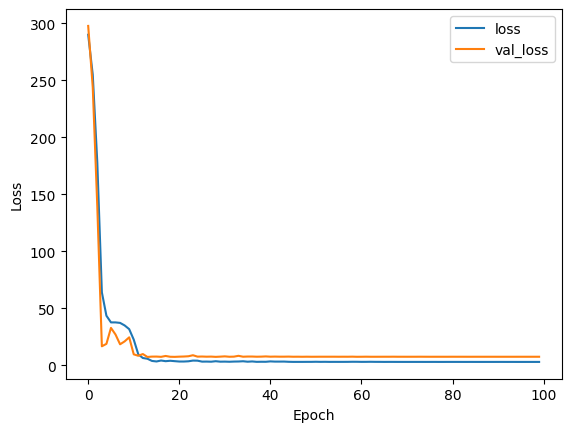

In [ ]:
# plot of loss and validation loss for each epoch
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_lstm = model.predict(X_valid)
loss_lstm = model.evaluate(X_valid, y_valid)
print(f"loss : {loss_lstm}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7860 
loss : 7.5024800300598145


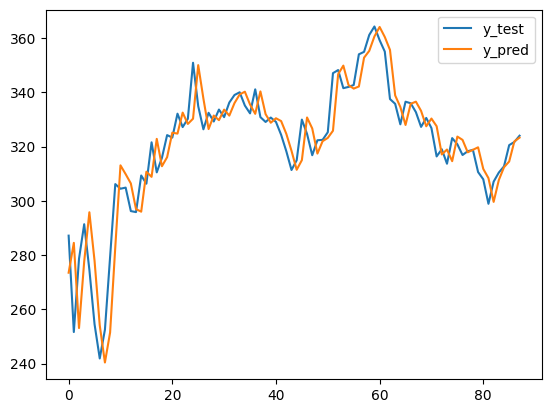

In [ ]:
# test vs predict graph
plt.plot(y_valid, label='y_test')
plt.plot(y_pred_lstm, label='y_pred')
plt.legend()
plt.show()

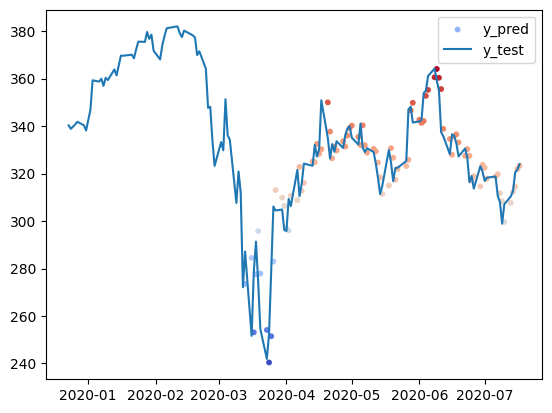

In [ ]:
# stock plot and predictions dots on it
plt.scatter(stock_data.iloc[split_time+65:].index, y_pred_lstm, label='y_pred', c = y_pred_lstm, cmap='coolwarm', s = 10)
plt.plot(stock_data.iloc[split_time+10:]['Close'], label='y_test')
plt.legend()
plt.show()

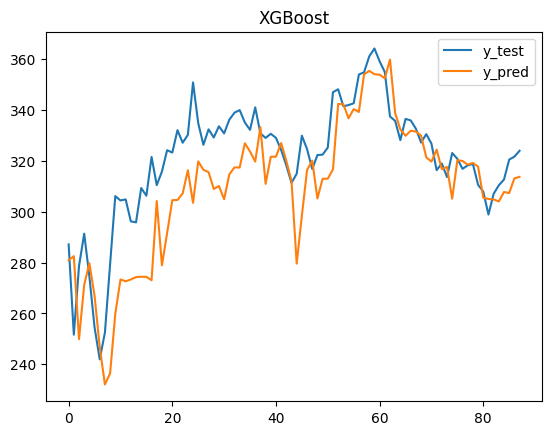

In [ ]:
# compare to XGBoost model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_valid)
plt.plot(y_valid, label='y_test')
plt.plot(y_pred_xgb, label='y_pred')
plt.title('XGBoost')
plt.legend()
plt.show()

NLP Models

In [ ]:
# create padded sentences array
X = np.array(padded.tolist())

In [ ]:
# unsupervised model to give sentiment to each sentence
vocab_size = len(tokenizer.word_index) + 1 # Size of the vocabulary
embedding_dim = 300  # Dimension of word embeddings

In [ ]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalAveragePooling1D(),

    # reshape the output of GlobalMaxPooling1D to be compatible with the LSTM layer
    Reshape((128,1)),

    # Bidirectional - process the input from both start and end of the sentences and combine the weights
    # LSTM - complex architecture to weigh then GRU, slower to train but can be more accurate due to the forget gate
    Bidirectional(LSTM(256, return_sequences=True)),
    LSTM(128),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation = 'sigmoid')
])

In [ ]:
pred = model.predict(X)

877/877 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step


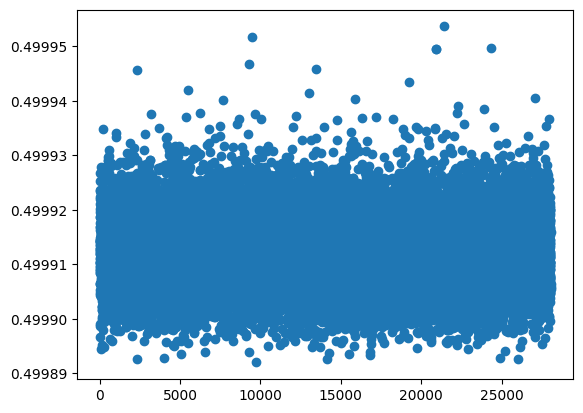

In [ ]:
plt.scatter(range(len(pred)), pred)
plt.show()

In [ ]:
reuters['Sentiment'] = pred

In [ ]:
# print 3 low and 3 high sentiment descriptions
masklow = reuters.sort_values('Sentiment').head(3)
maskhigh = reuters.sort_values('Sentiment', ascending = False).head(3)
print("low sentiment : ", masklow['Description'].head(3).values, "\n")
print("high sentiment : ", maskhigh['Description'].head(3).values)


low sentiment :  ['Hollywood has a new suitor in Silicon Valley.'
 'Frederick Baba, a managing director at Goldman Sachs who is black, sent the following email to colleagues at the bank on June 2:'
 'BMW  rivals and ride-hailing companies are considering joining its consortium for developing self-driving cars as auto industry profits come under increasing pressure, board member Klaus Froehlich said on Tuesday.'] 

high sentiment :  ['General Electric Co  predicted on Wednesday that the coronavirus would wipe out a substantial chunk of industrial free cash flow in the first quarter, but stuck to full-year financial targets the company set in January.GE predicted that the outbreak would erase $300 million to $500 million from industrial free cash flow and cause a hit of $200 million to $300 million to its first-quarter operating profit. GE set a forecast for first-quarter earnings of about 10 cents a sh'
 "Apple Inc was accused in a new lawsuit of securities fraud for concealing a slump 

Group sentiments for each date

In [ ]:
grouped_sentiments_mean = reuters.groupby('Date')['Sentiment'].mean()

In [ ]:
stock_data = pd.merge(stock_data, grouped_sentiments_mean, on='Date', how='left')

In [ ]:
stock_data.head()

,Close,High,Low,Open,Volume,Change,Sentiment
Date,,,,,,,
2018-07-18,267.078796,267.755324,264.347631,265.358242,860400,0,0.499913
2018-07-19,266.936737,267.989099,265.750712,266.686155,759900,0,0.499913
2018-07-20,269.400696,269.651278,265.132726,265.892781,1563900,0,0.499911
2018-07-23,265.876038,270.194144,264.589815,269.400673,1585300,-1,0.499911
2018-07-24,269.417328,275.330683,261.424254,271.446909,3253400,1,0.499912


In [ ]:
# print 3 low and 3 high sentiment descriptions
masklow = stock_data['Sentiment'].idxmin()
maskhigh = stock_data['Sentiment'].idxmax()
print("low sentiment : ", reuters.loc[masklow, 'Description'].values[:3], "\n")
print("high sentiment : ", reuters.loc[maskhigh, 'Description'].values[:3], "\n")

low sentiment :  ['Saudi Arabia said on Monday that the attack on its oil facilities was carried out with Iranian weapons, according to a preliminary investigation, but stopped short of directly blaming regional foe Iran.'
 "The weekend bombings of Saudi Arabia's main oil refinery have already sparked U.S. President Donald Trump to pressure the Federal Reserve anew to lower rates."
 'Members of the U.S. Congress blasted Iran after the attack on Saudi Arabian oil facilities, but expressed wariness about U.S. military action, especially before they have a clearer picture of who was behind it.'] 

high sentiment :  ["Boeing Co's recently aborted $4.2 billion agreement to buy the commercial jet-making operations of Brazil's Embraer specifically forbade either party from calling it off because of a pandemic or a global economic recession, Reuters has found."
 "Berkshire Hathaway Inc's  annual meeting will be nothing like the extravaganzas of years past, but will give Warren Buffett a chance

In [ ]:
# classic models classification - target column : 'Change'
X = stock_data.drop('Change', axis=1)
y = stock_data['Change']

# Change labels to [0, 1, 2] for xgboost classification
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# split to train and test
split_time = int(len(X)*0.8)
X_train, X_test = X[:split_time], X[split_time:]
y_train, y_test = y[:split_time], y[split_time:]

# scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create models dictionary to loop
models = {"logistic regrssion" : LogisticRegression(C = 10, solver = 'lbfgs'),
          "random forest" : RandomForestClassifier(n_estimators=250, min_samples_split=2, random_state=1),
          "xgboost" : XGBClassifier(eval_metric = 'mlogloss', objective='multi:softmax', tree_method = 'approx', n_estimators=250) }

# fit models on a loop, print and save performance data (accuracy, classification report and confusion matrix)
sentiment_accuracy = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    sentiment_accuracy[name] = accuracy
    print(f"{name} : {accuracy}")
    print(classification_report(y_test, y_pred))
    print("confusion_matrix : \n", confusion_matrix(y_test, y_pred), "\n")

logistic regrssion : 0.7326732673267327
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        36
           1       0.65      0.71      0.68        34
           2       0.72      0.74      0.73        31

    accuracy                           0.73       101
   macro avg       0.74      0.73      0.73       101
weighted avg       0.74      0.73      0.73       101

confusion_matrix : 
 [[27  7  2]
 [ 3 24  7]
 [ 2  6 23]] 

random forest : 0.5148514851485149
              precision    recall  f1-score   support

           0       0.73      0.53      0.61        36
           1       0.41      0.82      0.55        34
           2       0.71      0.16      0.26        31

    accuracy                           0.51       101
   macro avg       0.62      0.50      0.48       101
weighted avg       0.62      0.51      0.48       101

confusion_matrix : 
 [[19 17  0]
 [ 4 28  2]
 [ 3 23  5]] 

xgboost : 0.504950495049505
              p

In [ ]:
# compare to classic models
for classic, nlp in zip(classic_accuracy.items(), sentiment_accuracy.items()):
    print(classic[0], " : ")
    print(f"\tClassic : {classic[1]}")
    print(f"\tNLP : {nlp[1]}\n")

logistic regrssion  : 
	Classic : 0.7524752475247525
	NLP : 0.7326732673267327

random forest  : 
	Classic : 0.5445544554455446
	NLP : 0.5148514851485149

xgboost  : 
	Classic : 0.5445544554455446
	NLP : 0.504950495049505



In [ ]:
# חיזוי מגמות באמצעות מודל(LSTM (Series Time
def create_windows(series, window_size):
  X,y = [],[]
  for i in range(len(series) - window_size):
    X.append(series[i:i+window_size])
    y.append(series[i+window_size, 0])
  return np.array(X), np.array(y)

# quarter window size (about 65 trading days in a quarter)
window_size = 65

scaler = MinMaxScaler()
scaled = scaler.fit_transform(stock_data[['Close', 'Sentiment']])

X, y = create_windows(scaled, window_size)

In [ ]:
for i in range(1):
  print(f"{X[i]} => {y[i]}")

[[0.34105777 0.6561086 ]
 [0.34024313 0.63348416]
 [0.35437266 0.35746606]
 [0.33416057 0.42081448]
 [0.35446804 0.53393665]
 [0.36304176 0.80995475]
 [0.35624064 0.71945701]
 [0.36174867 0.57466063]
 [0.34268634 0.51131222]
 [0.37137556 0.66968326]
 [0.36577198 0.68778281]
 [0.35183407 0.78733032]
 [0.34479337 0.88687783]
 [0.3274074  0.53393665]
 [0.32975436 0.6561086 ]
 [0.31969591 0.80995475]
 [0.32161201 0.92760181]
 [0.30920696 0.59728507]
 [0.31169725 0.21266968]
 [0.33540571 0.78733032]
 [0.33114318 0.39819005]
 [0.37022579 0.74208145]
 [0.36720857 0.63348416]
 [0.36237133 0.58371041]
 [0.36318544 0.35294118]
 [0.35135492 0.54751131]
 [0.34220719 0.54298643]
 [0.34833822 0.61538462]
 [0.36294586 0.49773756]
 [0.36294586 0.36199095]
 [0.36284996 0.53393665]
 [0.35102031 0.71040724]
 [0.3537185  0.70135747]
 [0.36094821 0.60633484]
 [0.35815254 0.4479638 ]
 [0.39468484 0.58371041]
 [0.39285326 0.72850679]
 [0.36596028 0.35294118]
 [0.3624905  0.60180995]
 [0.37718984 0.56561086]


In [ ]:
# split to train and test
split_time = int(len(X)*0.8)
X_train, X_valid = X[:split_time], X[split_time:]
y_train, y_valid = y[:split_time], y[split_time:]

In [ ]:
# create tensor flow keras model
model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),

    # LSTM layer -
    LSTM(516, return_sequences=True),
    LSTM(256),

    # Dense layers - to add more processing to the data
    Dense(512, activation='relu'),

    # return one value
    Dense(1),
])

# compile model with adam optimizer and mae loss function
model.compile(
    optimizer=Adam(),
    loss='mae'
    )

# Add a callback to reduce the learning rate when the loss consistently decreases.
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)]

# fit model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.3528 - val_loss: 0.2290 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.1470 - val_loss: 0.1234 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0774 - val_loss: 0.1143 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0606 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0429 - val_loss: 0.0748 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0352 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0318 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0336 - val_loss: 0.0724 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0382 - val_loss: 0.0723 - learning_rate: 0.0010
Epoch 10/1

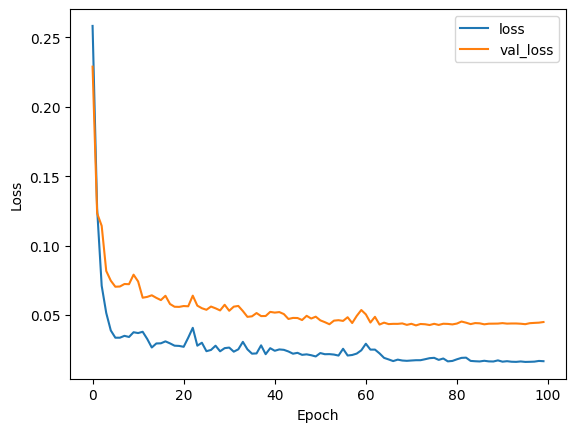

In [ ]:
# plot of loss and validation loss for each epoch
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_nlp = model.predict(X_valid)
loss_nlp = model.evaluate(X_valid, y_valid)
print(f"loss : {loss_nlp}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0519
loss : 0.04499325901269913


In [ ]:
# classic lstm vs nlp loss
print(f"classic loss : {loss_lstm}")
print(f"nlp loss : {loss_nlp}")

classic loss : 7.5024800300598145
nlp loss : 0.04499325901269913


Hard to compare loss between classic and nlp models - different features and scales

In [ ]:
# inverse scale
y_pred_nlp = scaler.inverse_transform(
    np.concatenate([y_pred_nlp.reshape(-1, 1), np.zeros_like(y_pred_nlp.reshape(-1, 1))], axis=1)
)[:, 0]  # Extract the first column (original target variable)
y_valid = scaler.inverse_transform(
    np.concatenate([y_valid.reshape(-1, 1), np.zeros_like(y_valid.reshape(-1, 1))], axis=1)
)[:, 0]  # Extract the first column (original target variable)

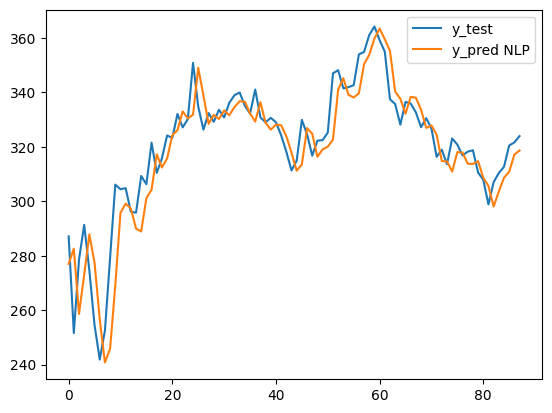

In [ ]:
# lstm predict vs nlp predict graph
plt.plot(y_valid, label='y_test')
plt.plot(y_pred_nlp, label='y_pred NLP')
plt.legend()
plt.show()

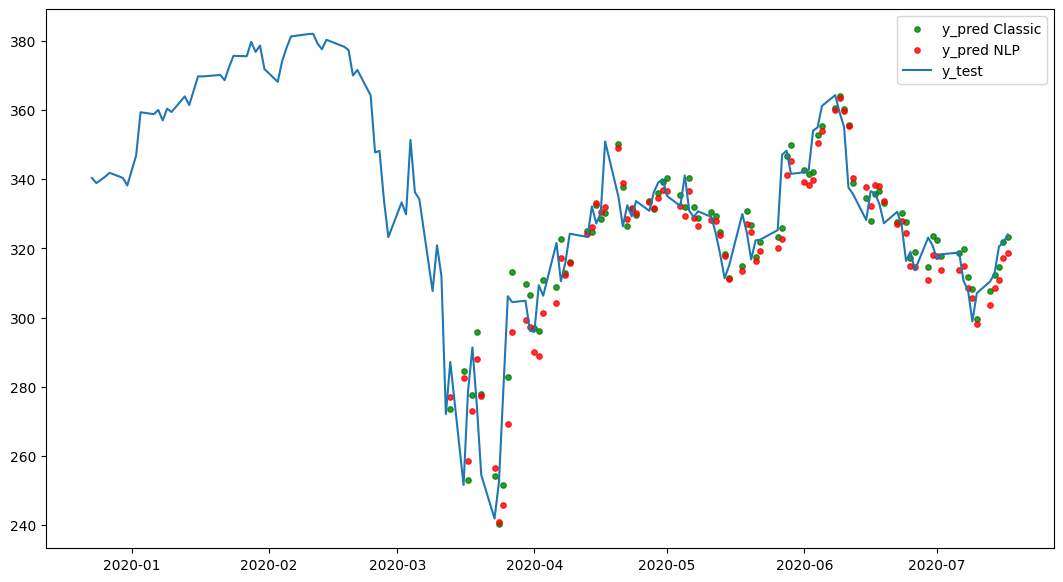

In [ ]:
# stock plot and predictions dots on it
fig, ax = plt.subplots(figsize=(13, 7))
plt.scatter(stock_data.iloc[split_time+65:].index, y_pred_lstm,
            label='y_pred Classic', c = 'g', s = 15, alpha = 0.8)

plt.scatter(stock_data.iloc[split_time+65:].index, y_pred_nlp,
            label='y_pred NLP', c = 'r', s = 15, alpha = 0.8)

plt.plot(stock_data.iloc[split_time+10:]['Close'], label='y_test')

plt.legend()
plt.show()

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
y_pred_xgb_nlp = xgb.predict(X_valid.reshape(X_valid.shape[0], -1))

# inverse scale
y_pred_xgb_nlp = scaler.inverse_transform(
    np.concatenate([y_pred_xgb_nlp.reshape(-1, 1), np.zeros_like(y_pred_xgb_nlp.reshape(-1, 1))], axis=1)
)[:, 0]  # Extract the first column (original target variable)


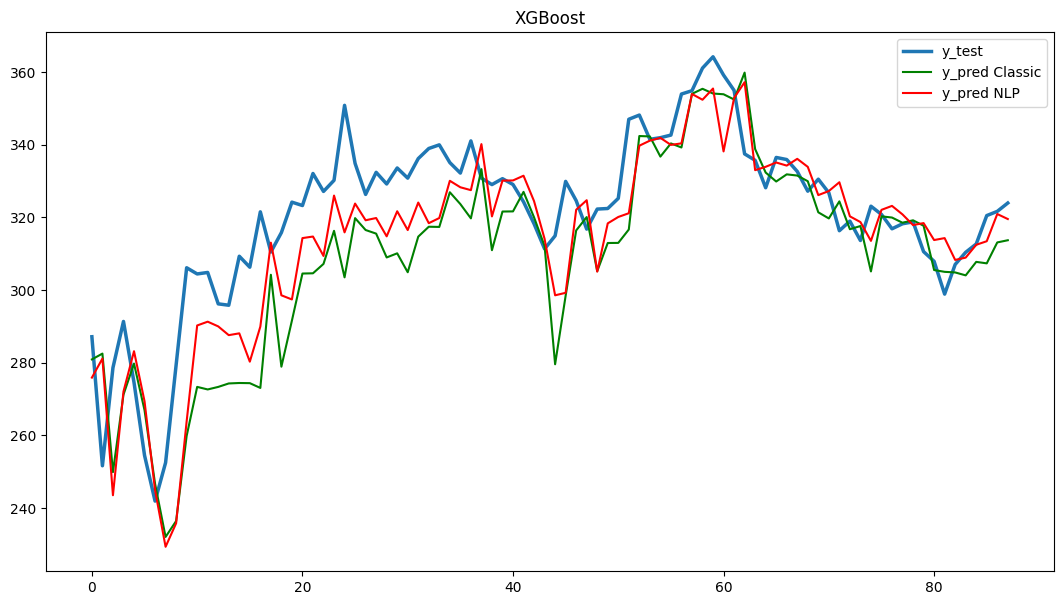

In [ ]:
# xgb predict vs xgb nlp predict graph
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot(y_valid, label='y_test', linewidth=2.5)
plt.plot(y_pred_xgb, label='y_pred Classic', c='g')
plt.plot(y_pred_xgb_nlp, label='y_pred NLP', c='r')
plt.title('XGBoost')
plt.legend()
plt.show()